In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  7 22:49:16 2019

@author: RedFox GIS & Remote Sensing, Aaron P.
"""
import numpy as np
from scipy import ndimage as nd
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import rasterio
from matplotlib import pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from rasterio.features import shapes
from skimage.segmentation import quickshift, mark_boundaries
from skimage import io, color
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from rasterstats import zonal_stats
import time

In [2]:
indata = '/Users/aaron/gdrive/projects/image_segmentation_project/data/river_subset.tif'
training_data = '/Users/aaron/gdrive/projects/image_segmentation_project/data/training_data.shp'
outdata = '/Users/aaron/Desktop/temp/RF_results.shp'

## Read image and calculate statistics

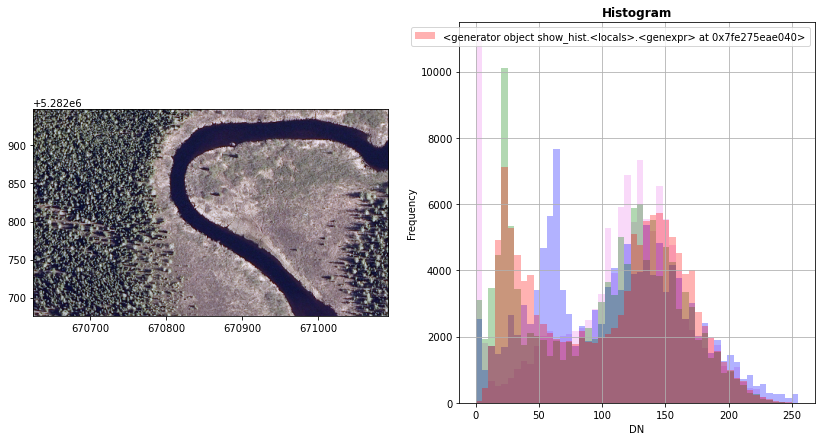

In [3]:
# Read in 4 band NAIP image
dataset = rasterio.open(indata)

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

# Get image bounding box info
sr = dataset.crs
bounds = dataset.bounds
affine = dataset.transform

## Segment Image

Quickshift number of segments: 406


/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image))


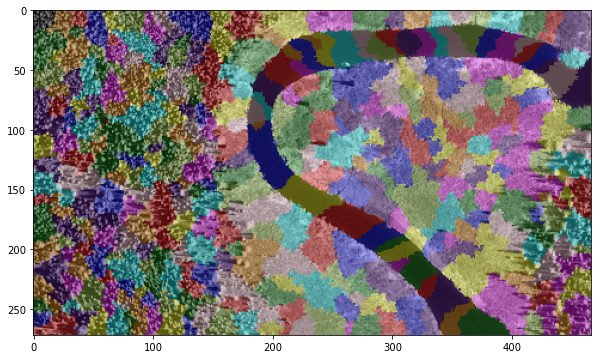

In [4]:
img = io.imread(indata)
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# Convert to vector features
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

## Calculate NDVI

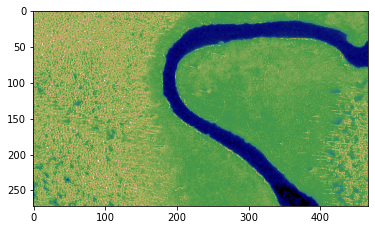

<AxesSubplot:>

In [5]:
red = dataset.read(3).astype(float)
nir = dataset.read(4).astype(float)

#Allow 0 in division
np.seterr(divide='ignore', invalid='ignore')

ndvi = np.empty(dataset.shape, dtype=rasterio.float32)
check = np.logical_or ( red > 0, nir > 0 )
ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )
show(ndvi, cmap='gist_earth')

# Optional
# Normalize and scale NDVI to Uint 8
#data = ndvi / np.amax(ndvi) # normalize the data to 0 - 1
#data = 255 * data # Now scale by 255
#img = data.astype(np.uint8)
#show(img, cmap='gist_earth')


## Calculate Entropy and Texture Metrics

In [6]:
# Entropy
# https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html#sphx-glr-auto-examples-filters-plot-entropy-py
entr_img = entropy(ndvi, disk(10))

/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Gabor Filter Bank

In [7]:

shrink = (slice(0, None, 1), slice(0, None, 1))
ndvi = img_as_float(ndvi)[shrink]
b1 = img_as_float(dataset.read(1))[shrink]
b2 = img_as_float(dataset.read(2))[shrink]
b3 = img_as_float(dataset.read(3))[shrink]
b4 = img_as_float(dataset.read(4))[shrink]
image_names = ('ndvi', 'b1', 'b2', 'b3', 'b4')
images = (ndvi, b1, b2, b3, b4)

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

## Convert segments to geodataframe

In [8]:
geom = [shape(i) for i in polys]
polys_gdf = gpd.GeoDataFrame({'geometry':geom})

# Set sr
polys_gdf.crs = sr

# Check results
polys_gdf.head()

,geometry
0,"POLYGON ((670625.002 5282947.795, 670625.002 5..."
1,"POLYGON ((670871.002 5282947.795, 670871.002 5..."
2,"POLYGON ((670971.002 5282947.795, 670971.002 5..."
3,"POLYGON ((670992.002 5282947.795, 670992.002 5..."
4,"POLYGON ((670923.002 5282947.795, 670923.002 5..."


## Zonal statistics and convert to geodataframe

In [9]:
# Dictionary containing band name and band data
var_dict = {'ndvi':ndvi, 
            'entropy':entr_img, 
            'red':dataset.read(1), 
            'green':dataset.read(2), 
            'blue':dataset.read(3), 
            'nir':dataset.read(4),
            'gabor_ndvi_th0_fr10': results[0][1][0],
            'gabor_b1_th0_fr10': results[0][1][1],
            'gabor_b2_th0_fr10': results[0][1][2],
            'gabor_b3_th0_fr10': results[0][1][3],
            'gabor_b4_th0_fr10': results[0][1][4],
            'gabor_ndvi_th0_fr40': results[1][1][0],
            'gabor_b1_th0_fr40': results[1][1][1],
            'gabor_b2_th0_fr40': results[1][1][2],
            'gabor_b3_th0_fr40': results[1][1][3],
            'gabor_b4_th0_fr40': results[1][1][4],   
            'gabor_ndvi_th45_fr10': results[2][1][0],
            'gabor_b1_th45_fr10': results[2][1][1],
            'gabor_b2_th45_fr10': results[2][1][2],
            'gabor_b3_th45_fr10': results[2][1][3],
            'gabor_b4_th45_fr10': results[2][1][4],  
            'gabor_ndvi_th45_fr40': results[3][1][0],
            'gabor_b1_th45_fr40': results[3][1][1],
            'gabor_b2_th45_fr40': results[3][1][2],
            'gabor_b3_th45_fr40': results[3][1][3],
            'gabor_b4_th45_fr40': results[3][1][4]            
           }

# List of stats used in zonal stats function
stats_list = ['min', 
                 'max', 
                 'mean', 
                 'count', 
                 'sum', 
                 'std', 
                 'median', 
                 'majority', 
                 'minority', 
                 'unique', 
                 'range', 
                 'percentile_1', 
                 'percentile_10', 
                 'percentile_20', 
                 'percentile_30', 
                 'percentile_40', 
                 'percentile_50', 
                 'percentile_60', 
                 'percentile_70', 
                 'percentile_80', 
                 'percentile_90', 
                 'percentile_99']

start = time.time()

for key, value in var_dict.items():
    zs = zonal_stats(polys, value, affine = affine, stats=stats_list)

    # Summarize all the dictionaries into one dataframe
    df = pd.DataFrame(zs)
    
    # Add band prefix to column name in DF
    name = key + "_"
    df = df.add_prefix(name)
    
    polys_gdf = pd.concat([polys_gdf, df], axis=1)

end = time.time()

print(f"Zonal statistics took: {round(end-start, 2)} seconds")
    
# Check results
polys_gdf.head()

/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Zonal statistics took: 33.84 seconds


,geometry,ndvi_min,ndvi_max,ndvi_mean,ndvi_count,ndvi_sum,ndvi_std,ndvi_median,ndvi_majority,ndvi_minority,...,gabor_b4_th45_fr40_percentile_10,gabor_b4_th45_fr40_percentile_20,gabor_b4_th45_fr40_percentile_30,gabor_b4_th45_fr40_percentile_40,gabor_b4_th45_fr40_percentile_50,gabor_b4_th45_fr40_percentile_60,gabor_b4_th45_fr40_percentile_70,gabor_b4_th45_fr40_percentile_80,gabor_b4_th45_fr40_percentile_90,gabor_b4_th45_fr40_percentile_99
0,"POLYGON ((670625.002 5282947.795, 670625.002 5...",-0.125307,1.000000,0.359136,303,108.818217,0.301862,0.298429,1.000000,-0.125307,...,0.042015,0.065761,0.078929,0.091933,0.109588,0.118233,0.134695,0.148748,0.168714,0.201790
1,"POLYGON ((670871.002 5282947.795, 670871.002 5...",-0.321429,0.145946,-0.080569,378,-30.455098,0.069604,-0.089975,0.000000,-0.321429,...,0.014823,0.021776,0.025833,0.031272,0.035560,0.039159,0.045854,0.056308,0.071708,0.122389
2,"POLYGON ((670971.002 5282947.795, 670971.002 5...",-0.282051,0.171717,-0.018852,219,-4.128579,0.077129,-0.016611,-0.109756,-0.282051,...,0.011451,0.016824,0.021840,0.026825,0.034861,0.041836,0.047138,0.055698,0.070644,0.089822
3,"POLYGON ((670992.002 5282947.795, 670992.002 5...",-0.281437,0.486239,-0.056795,229,-13.006013,0.102738,-0.073620,-0.107527,-0.281437,...,0.020689,0.029840,0.037432,0.045595,0.051721,0.060794,0.068080,0.081397,0.093381,0.112075
4,"POLYGON ((670923.002 5282947.795, 670923.002 5...",-0.347670,0.517241,-0.046072,240,-11.057297,0.085510,-0.058376,0.000000,-0.347670,...,0.013992,0.022586,0.026091,0.030598,0.035415,0.041922,0.048280,0.055524,0.068045,0.097694


## Generate training Data

In [10]:
# Read in shapefile with ground truth classes
gdf = gpd.read_file(training_data)

class_names = gdf['label'].unique()

# Assign integer to class names
class_ids = np.arange(class_names.size) + 1

# Add a new column and assign integer value to correspoding label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

# Spatial Join
data = gpd.sjoin(gdf, polys_gdf, how='left')

data.head()

,id,label,geometry,index_right,ndvi_min,ndvi_max,ndvi_mean,ndvi_count,ndvi_sum,ndvi_std,...,gabor_b4_th45_fr40_percentile_10,gabor_b4_th45_fr40_percentile_20,gabor_b4_th45_fr40_percentile_30,gabor_b4_th45_fr40_percentile_40,gabor_b4_th45_fr40_percentile_50,gabor_b4_th45_fr40_percentile_60,gabor_b4_th45_fr40_percentile_70,gabor_b4_th45_fr40_percentile_80,gabor_b4_th45_fr40_percentile_90,gabor_b4_th45_fr40_percentile_99
0,1,forest,POINT (670655.345 5282861.972),163,-0.145631,1.0,0.281459,155,43.626100,0.282063,...,0.043711,0.052634,0.067700,0.075824,0.083610,0.090117,0.098326,0.107212,0.134063,0.165977
1,1,forest,POINT (670756.515 5282891.345),116,-0.148936,1.0,0.249655,258,64.411076,0.258929,...,0.036888,0.052789,0.066280,0.076792,0.090168,0.102813,0.123299,0.140399,0.182946,0.227866
2,1,forest,POINT (670761.003 5282933.771),25,-0.245902,1.0,0.300445,355,106.658001,0.321100,...,0.029154,0.043265,0.059642,0.074158,0.090018,0.109021,0.126030,0.147601,0.174337,0.265671
3,1,forest,POINT (670646.778 5282934.179),20,-0.171875,1.0,0.337188,348,117.341544,0.281483,...,0.032705,0.045989,0.057071,0.071800,0.080914,0.090630,0.099494,0.110114,0.126167,0.159620
4,1,forest,POINT (670651.266 5282748.564),364,-0.420290,1.0,0.166562,111,18.488401,0.326316,...,0.018868,0.026631,0.036935,0.051081,0.061597,0.072996,0.080458,0.097161,0.111372,0.148219


## Split data into train and test sets

In [11]:
# Get a list of all the variables from the df column names
var_list = polys_gdf.columns.drop(['geometry'])

# Create dependent and independent variables
x = data[var_list]
y = data[['id']]

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [12]:
x.head()

,ndvi_min,ndvi_max,ndvi_mean,ndvi_count,ndvi_sum,ndvi_std,ndvi_median,ndvi_majority,ndvi_minority,ndvi_unique,...,gabor_b4_th45_fr40_percentile_10,gabor_b4_th45_fr40_percentile_20,gabor_b4_th45_fr40_percentile_30,gabor_b4_th45_fr40_percentile_40,gabor_b4_th45_fr40_percentile_50,gabor_b4_th45_fr40_percentile_60,gabor_b4_th45_fr40_percentile_70,gabor_b4_th45_fr40_percentile_80,gabor_b4_th45_fr40_percentile_90,gabor_b4_th45_fr40_percentile_99
0,-0.145631,1.0,0.281459,155,43.626100,0.282063,0.232877,1.000000,-0.145631,145,...,0.043711,0.052634,0.067700,0.075824,0.083610,0.090117,0.098326,0.107212,0.134063,0.165977
1,-0.148936,1.0,0.249655,258,64.411076,0.258929,0.186692,1.000000,-0.148936,238,...,0.036888,0.052789,0.066280,0.076792,0.090168,0.102813,0.123299,0.140399,0.182946,0.227866
2,-0.245902,1.0,0.300445,355,106.658001,0.321100,0.215311,1.000000,-0.245902,319,...,0.029154,0.043265,0.059642,0.074158,0.090018,0.109021,0.126030,0.147601,0.174337,0.265671
3,-0.171875,1.0,0.337188,348,117.341544,0.281483,0.291429,1.000000,-0.171875,317,...,0.032705,0.045989,0.057071,0.071800,0.080914,0.090630,0.099494,0.110114,0.126167,0.159620
4,-0.420290,1.0,0.166562,111,18.488401,0.326316,0.115385,-0.121951,-0.420290,103,...,0.018868,0.026631,0.036935,0.051081,0.061597,0.072996,0.080458,0.097161,0.111372,0.148219


## Classify

In [13]:
#Create a RF Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train.values.ravel())

y_pred=clf.predict(x_test)

In [14]:
y_pred

array([2, 1, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 3, 3, 1, 3, 2, 1])

In [15]:
x_test

,ndvi_min,ndvi_max,ndvi_mean,ndvi_count,ndvi_sum,ndvi_std,ndvi_median,ndvi_majority,ndvi_minority,ndvi_unique,...,gabor_b4_th45_fr40_percentile_10,gabor_b4_th45_fr40_percentile_20,gabor_b4_th45_fr40_percentile_30,gabor_b4_th45_fr40_percentile_40,gabor_b4_th45_fr40_percentile_50,gabor_b4_th45_fr40_percentile_60,gabor_b4_th45_fr40_percentile_70,gabor_b4_th45_fr40_percentile_80,gabor_b4_th45_fr40_percentile_90,gabor_b4_th45_fr40_percentile_99
31,-0.970588,0.629630,-0.796931,405,-322.757030,0.262324,-0.904762,-0.909091,-0.970588,155,...,0.001997,0.002651,0.003078,0.003579,0.004014,0.004857,0.006825,0.017848,0.047373,0.090594
9,-0.318519,1.000000,0.122853,540,66.340662,0.245591,0.071038,1.000000,-0.318519,494,...,0.021632,0.030922,0.039662,0.048495,0.060885,0.072296,0.084115,0.101174,0.133164,0.181185
10,-0.167173,1.000000,0.282795,596,168.546112,0.286274,0.212775,1.000000,-0.167173,544,...,0.031138,0.046006,0.059070,0.069608,0.081877,0.093795,0.106589,0.125531,0.164994,0.261407
2,-0.245902,1.000000,0.300445,355,106.658001,0.321100,0.215311,1.000000,-0.245902,319,...,0.029154,0.043265,0.059642,0.074158,0.090018,0.109021,0.126030,0.147601,0.174337,0.265671
58,-0.237785,0.439252,-0.045336,329,-14.915417,0.087119,-0.057143,0.000000,-0.237785,294,...,0.015004,0.021585,0.026466,0.033325,0.039883,0.048859,0.058099,0.069408,0.088509,0.154358
52,-0.078947,0.507937,0.040917,293,11.988635,0.065724,0.034146,0.000000,-0.078947,246,...,0.010647,0.015752,0.021123,0.026147,0.029691,0.033447,0.039519,0.045036,0.062698,0.107617
56,-0.276873,0.161677,-0.049383,360,-17.777777,0.064893,-0.057258,0.000000,-0.276873,323,...,0.016878,0.023820,0.032841,0.040569,0.045454,0.051596,0.059093,0.072620,0.089546,0.133320
29,-1.000000,1.000000,-0.784374,457,-358.458769,0.330530,-0.913043,-0.935484,-0.970588,168,...,0.001822,0.002493,0.002984,0.003624,0.004328,0.005044,0.006765,0.017942,0.045658,0.140911
32,-1.000000,1.000000,-0.781828,564,-440.951227,0.293082,-0.904762,-0.935484,-1.000000,193,...,0.001769,0.002585,0.003115,0.003580,0.004005,0.004708,0.005889,0.014065,0.053465,0.149553
8,-0.187135,1.000000,0.193011,95,18.336058,0.225129,0.161905,0.333333,-0.187135,94,...,0.029034,0.037459,0.048857,0.058470,0.068010,0.075289,0.085595,0.097531,0.109614,0.144812


## Assess Accuracy

In [16]:
#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


## Assess feature importance

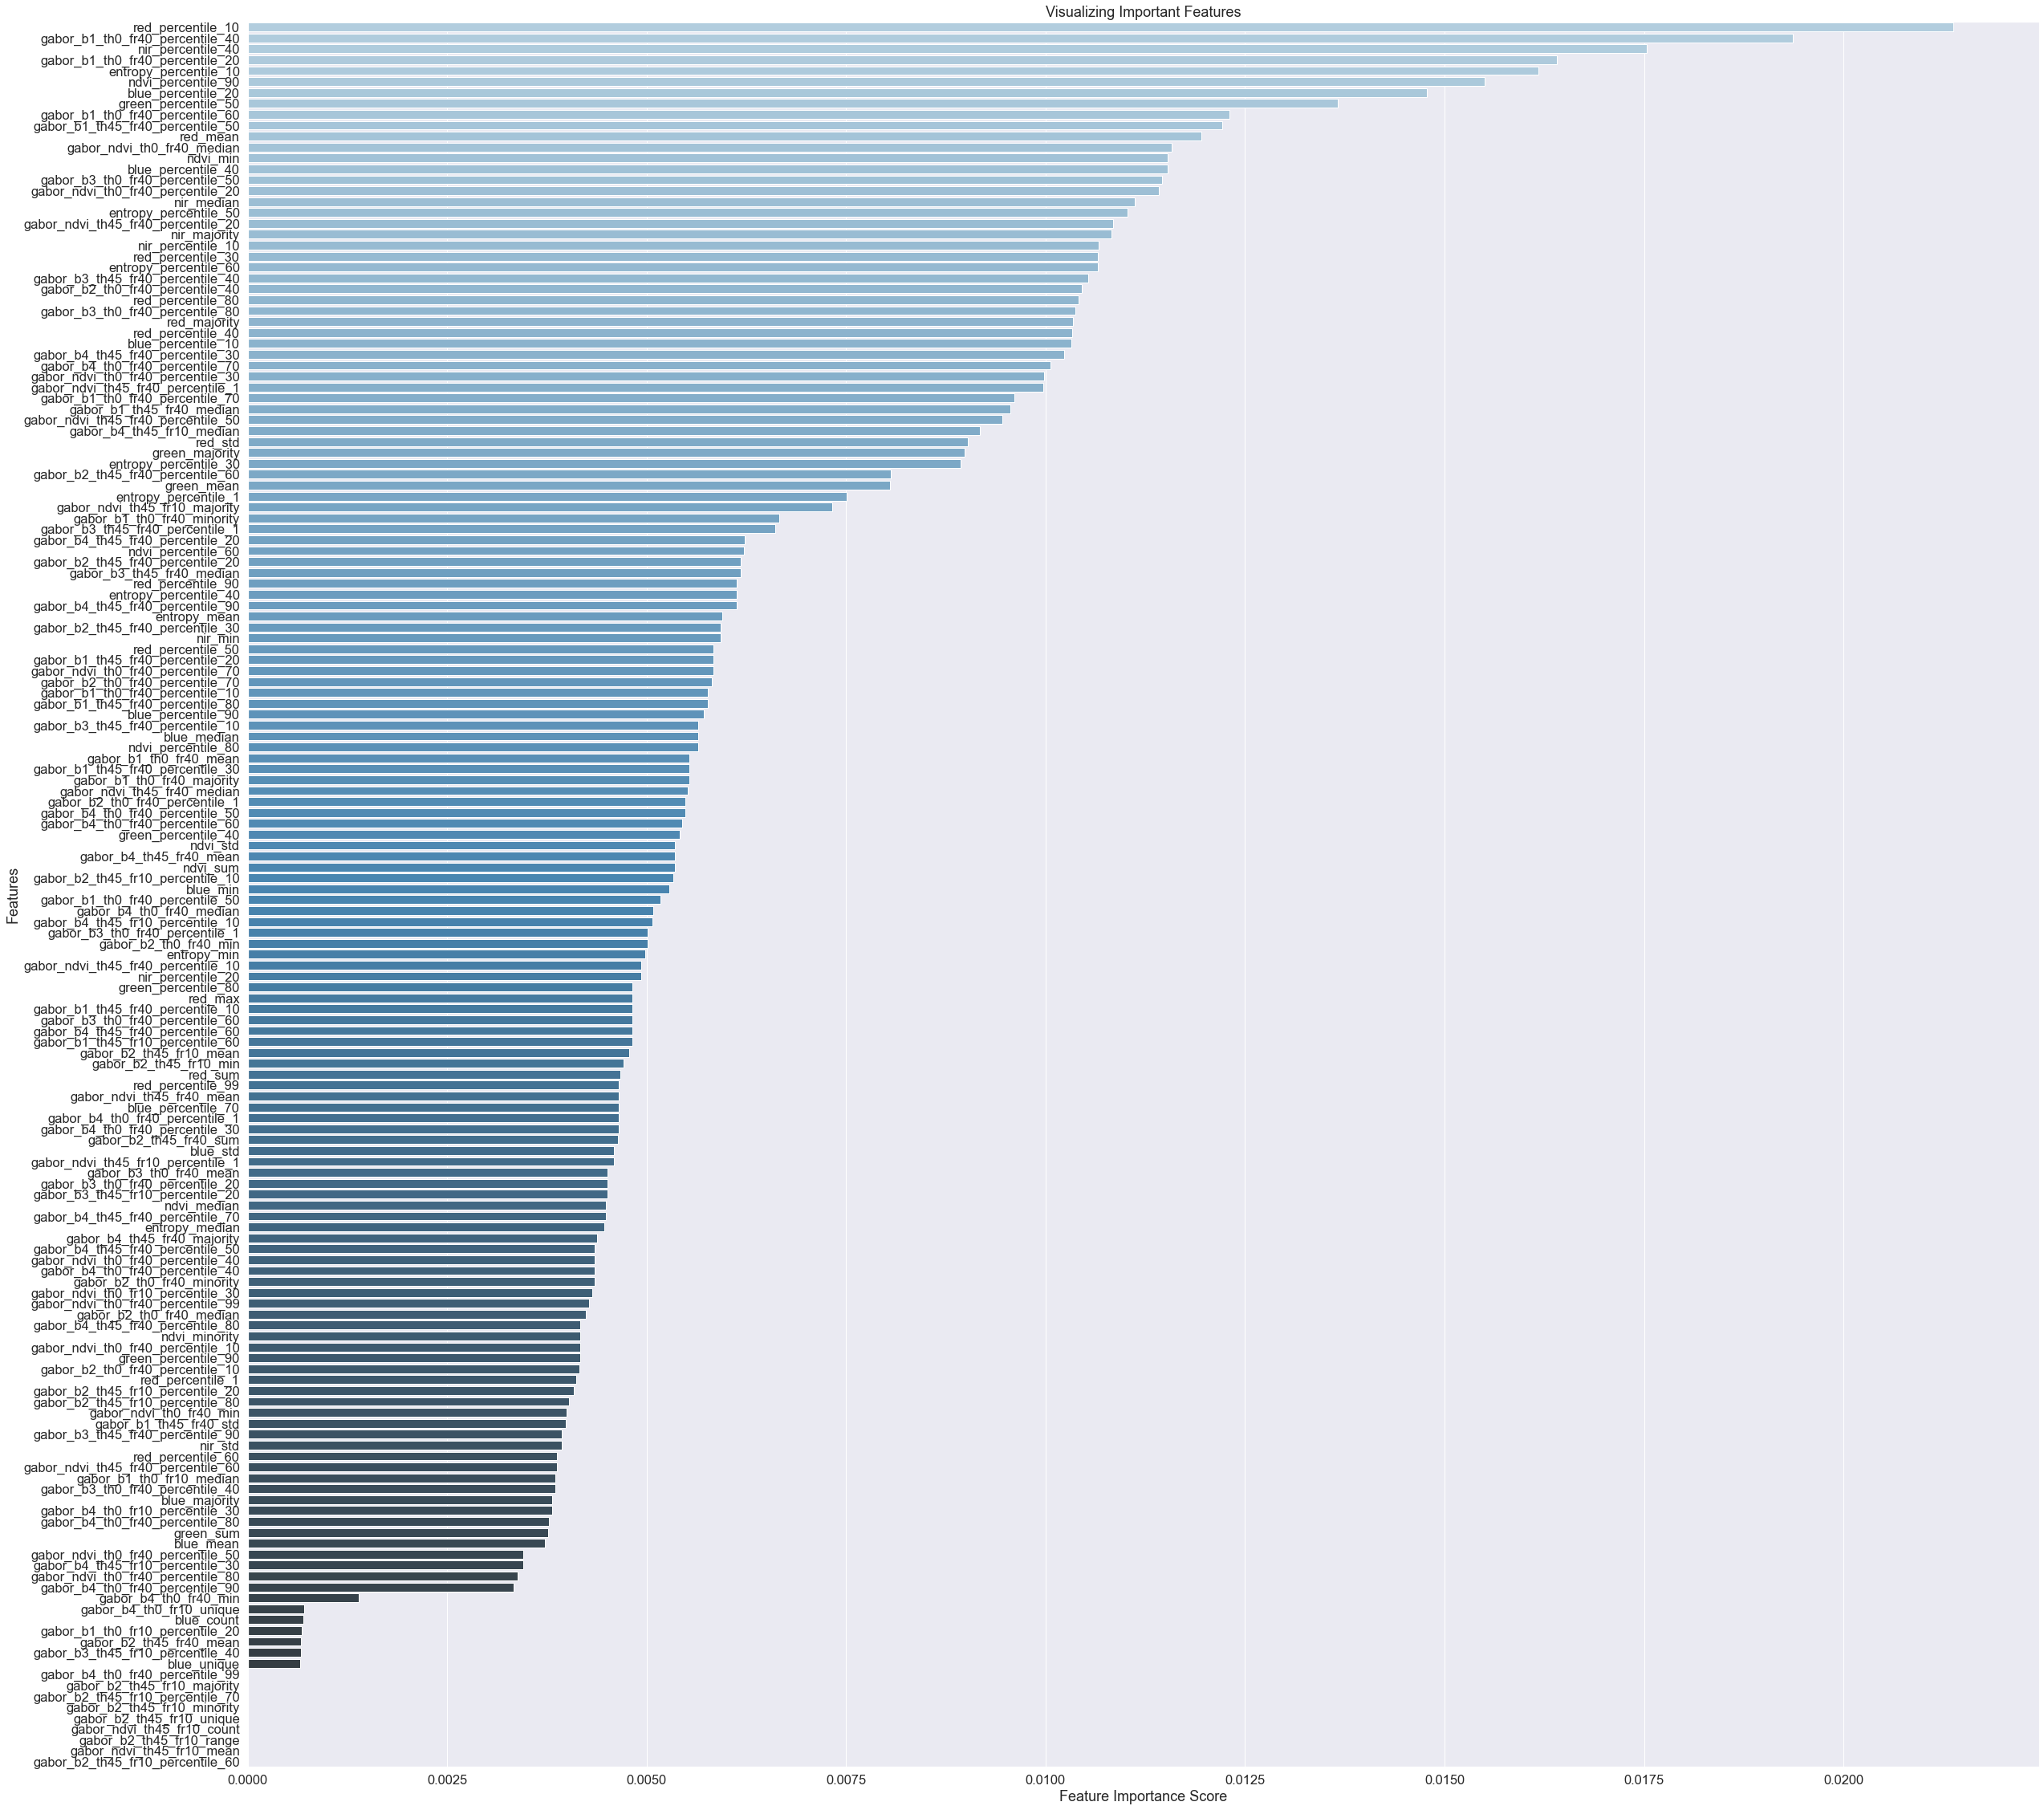

In [17]:
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python

# Plot the top 100 predictors
feature_imp = pd.Series(clf.feature_importances_, index=x_test.columns).sort_values(ascending=False)[:160]

# Creating a bar plot
sns.set(rc={'figure.figsize':(40,40)}, font_scale=1.5)
sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


In [18]:
feature_imp[:100]

red_percentile_10                  0.021378
gabor_b1_th0_fr40_percentile_40    0.019364
nir_percentile_40                  0.017529
gabor_b1_th0_fr40_percentile_20    0.016404
entropy_percentile_10              0.016178
                                     ...   
gabor_b2_th45_fr10_min             0.004712
red_sum                            0.004667
red_percentile_99                  0.004647
gabor_ndvi_th45_fr40_mean          0.004647
blue_percentile_70                 0.004647
Length: 100, dtype: float64

## Predict on all segments

In [19]:
# Get the original data and convert to 2-D array
#data2 = pd.DataFrame(polys_gdf[['ndvi_mean', 'entropy_mean', 'red_mean', 'green_mean', 'blue_mean', 'nir_mean']])
data2 = pd.DataFrame(polys_gdf[var_list])

# Predict
y2_pred=clf.predict(data2) # Creates an array of predictions

# Append predict array to geopandas gdf
polys_gdf['class'] = y2_pred

## Map it

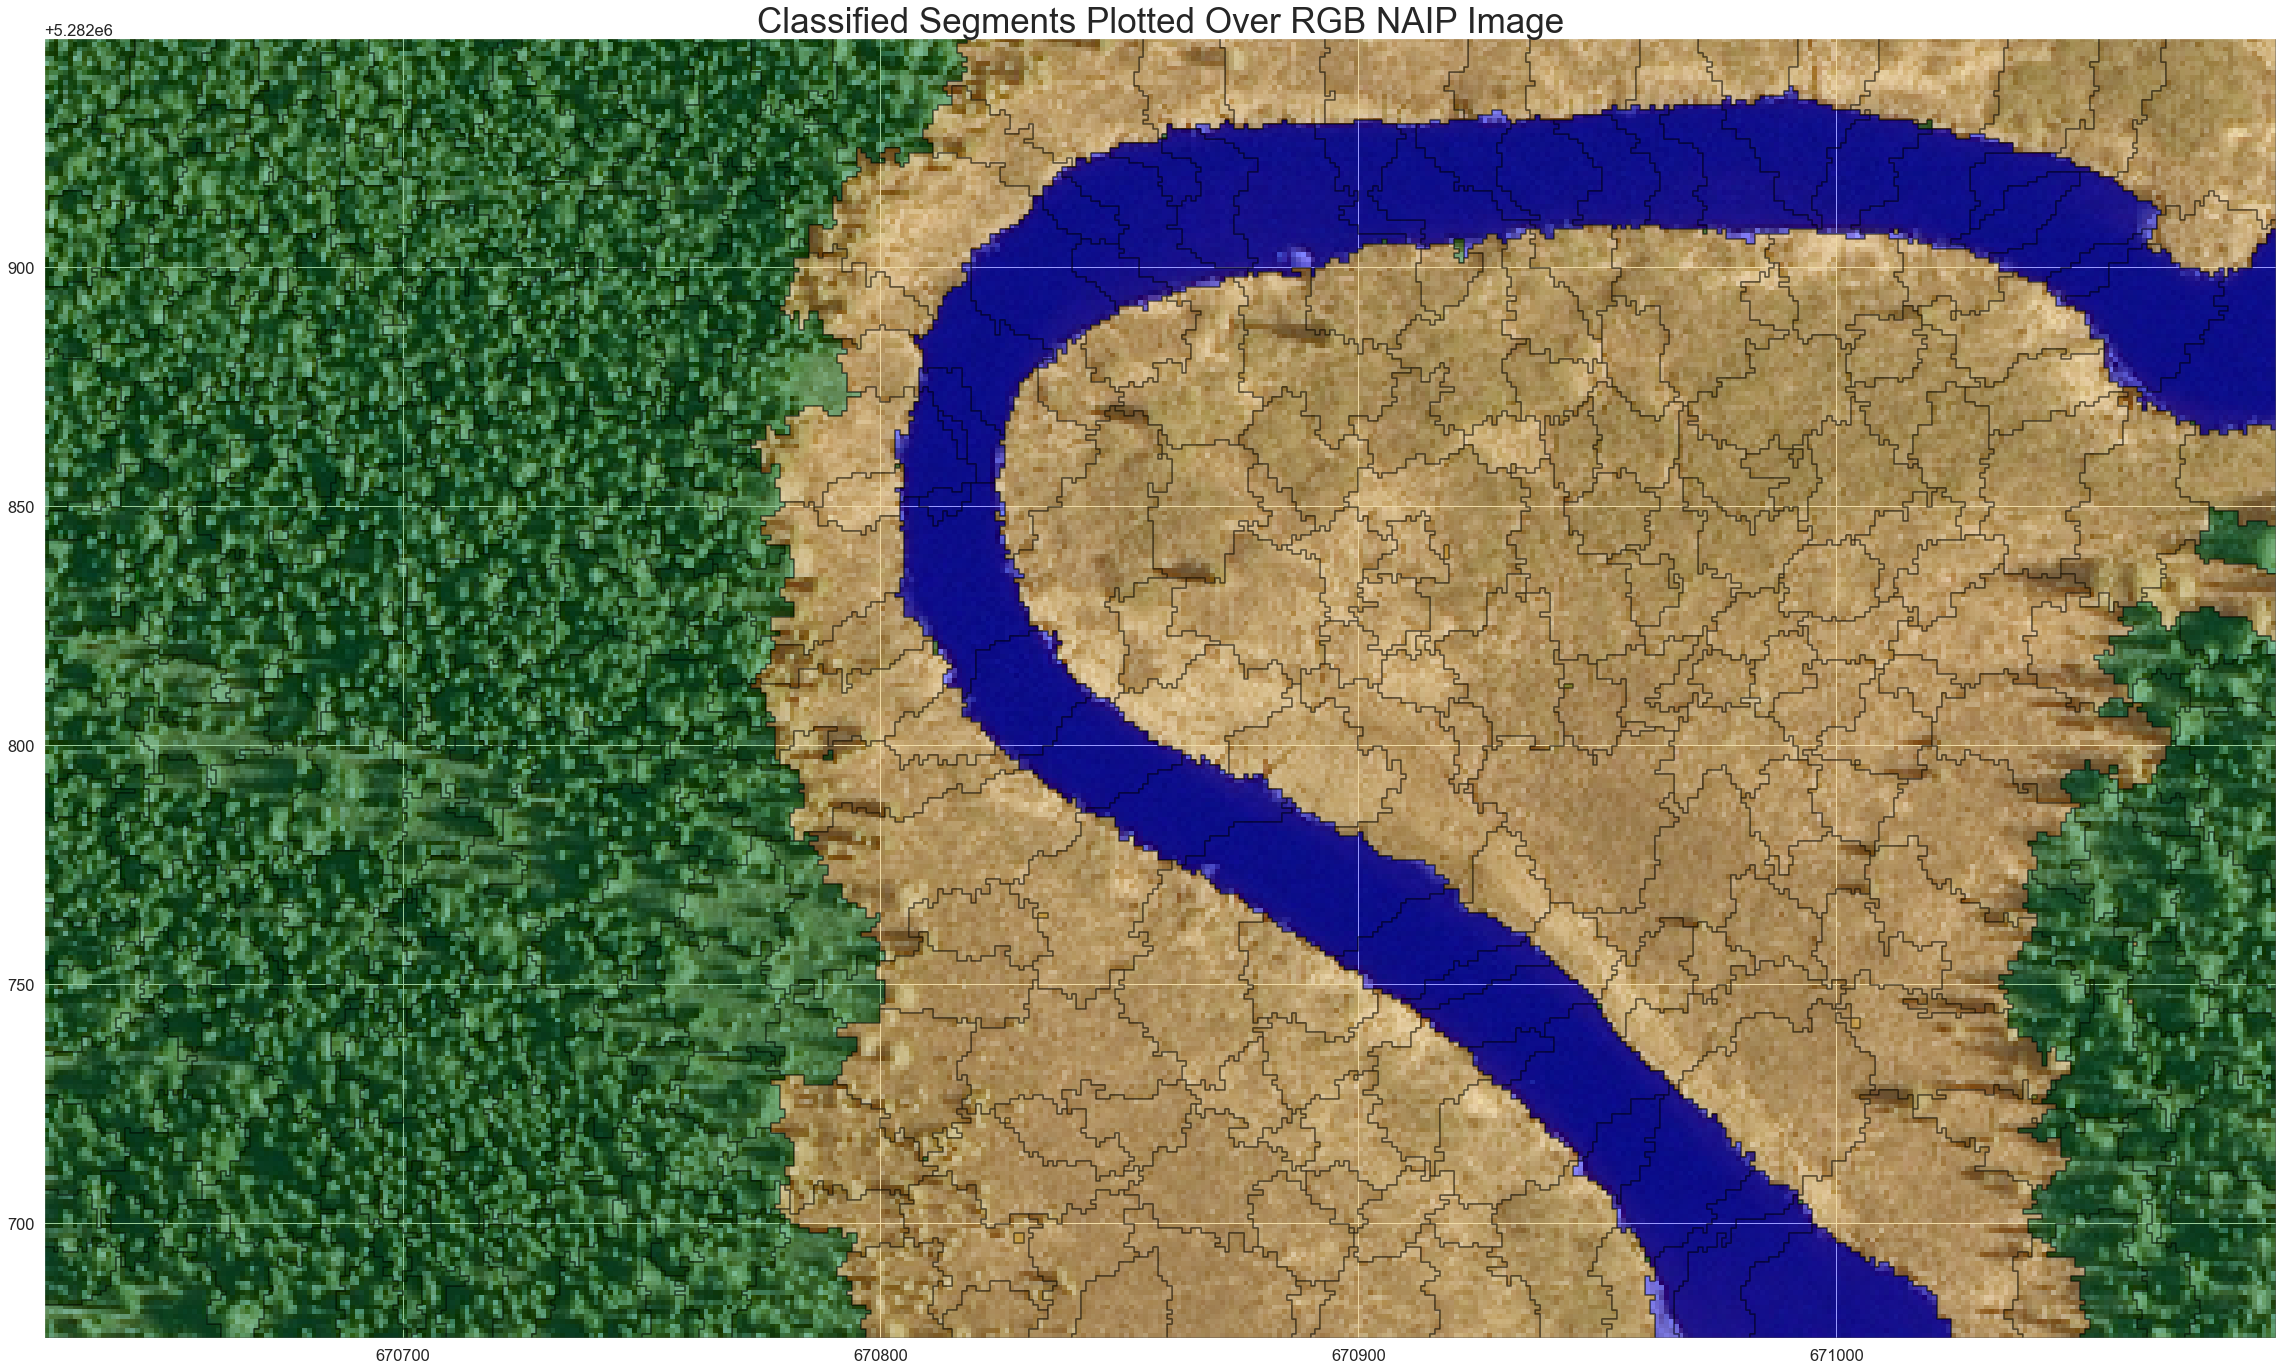

In [20]:
# Plot classified segments over RGB image
f, ax = plt.subplots()
ax.set_title("Classified Segments Plotted Over RGB NAIP Image", fontsize=35)

show(dataset, ax = ax)

sns.set(rc={'figure.figsize':(20,20)}) # Set figure size
color_mapping = {1: "green", 2: "blue", 3: "goldenrod"} # Custom color scheme
polys_gdf.plot(ax = ax, 
               color=polys_gdf["class"].map(color_mapping), 
               alpha = 0.4, 
               edgecolor='black',
               linewidth=1.5) # Apply colors based on class column

plt.show()

## Dissolve segments and export to shp

In [21]:
# Dissolve segments
dissolved_segments = polys_gdf.dissolve(by = 'class', aggfunc = 'sum')
dissolved_segments.crs = sr
dissolved_segments.to_file(outdata)

# Export all segs to shp
#polys_gdf.crs = sr # Make sure the SR is defined the same as input data
#polys_gdf.to_file(outdata)

## Testing GLCM in progress...

In [22]:
# # In progress...
# # Eventually add texture metrics to raster stack for classification

# # And GLCM Texture Features
# from skimage.feature import greycomatrix, greycoprops
# # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
# glcm = greycomatrix(dataset.read(4), distances=[5], angles=[0], levels=256,
#                     symmetric=True, normed=True)

# #plt.imshow(glcm, cmap = 'gray')